### Import Modules

In [1]:
import os
import shutil
import csv
import ast
import re
import yaml

import numpy as np
import pandas as pd
import seaborn as sns
import dask.array as da
import dask.dataframe as dd
import pickle as pkl

from Bio import SeqIO
from Bio.Seq import Seq
from time import sleep
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
from IPython.core.display import display, HTML

from matplotlib import pyplot as plt

/tmp/ipykernel_2763/490426756.py:12: DeprecationWarning: The current Dask DataFrame implementation is deprecated. 
In a future release, Dask DataFrame will use new implementation that
contains several improvements including a logical query planning.
The user-facing DataFrame API will remain unchanged.

The new implementation is already available and can be enabled by
installing the dask-expr library:

    $ pip install dask-expr

and turning the query planning option on:

    >>> import dask
    >>> dask.config.set({'dataframe.query-planning': True})
    >>> import dask.dataframe as dd

API documentation for the new implementation is available at
https://docs.dask.org/en/stable/dask-expr-api.html

Any feedback can be reported on the Dask issue tracker
https://github.com/dask/dask/issues 

  import dask.dataframe as dd
/tmp/ipykernel_2763/490426756.py:20: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display


### Define Functions

In [2]:
def align_read(querystr,cigarstr,pattern=re.compile("[0-9]{0,10}[MDI]")):
    result = pattern.finditer(cigarstr)
    cigar_seq = [(item.group(0)[-1],int(item.group(0)[:-1])) for item in result]
    output_str = ""
    current_idx = 0
    for item in cigar_seq:
        if item[0]=="M":
            added_str = querystr[current_idx:current_idx+item[1]]
            output_str += added_str
            current_idx += item[1]
        elif item[0]=="D":
            added_str = "".join(["-" for i in range(item[1])])
            output_str += added_str
        elif item[0]=="I":
            current_idx += item[1]
    return output_str

def cigarsfromsam(samfilepath):
    cigars = {}
    with open(samfilepath,"r") as samfile:
        for line in samfile:
            if line[0]=="@":
                next(samfile)
            else:
                splitline = line.split("\t")
                cigars[splitline[0]] = splitline[5]
    return cigars

def strsfromfasta(fastafilepath):
    queries = SeqIO.to_dict(SeqIO.parse(fastafilepath,"fasta"))
    queries = {key: str(val.seq) for key,val in queries.items()}
    return queries

def make_seg_dict(gfafile):
    segment_dict = {}
    with open(gfafile,"r") as infile:
        for line in infile:
            if line[0] == "S":
                splitline = line.split("\t")
                segment_dict[splitline[1]] = splitline[2][:-1]
    return segment_dict

def get_ref_intervals(gfafile):
    segment_dict = {}
    current_idx = 0
    with open(gfafile,"r") as infile:
        for line in infile:
            if line[0] == "S":
                splitline = line.split("\t")
                if "OFF" not in splitline[1]:
                    refstr = splitline[2][:-1]
                    strlen = len(refstr)
                    name = splitline[1]
                    if "ON" in name:
                        name=name[:-2]
                    segment_dict[name] = tuple((current_idx,current_idx+strlen))
                    current_idx += strlen
    return segment_dict
    
def align_read(querystr,refstr,cigarstr,startpos=1,pattern=re.compile("[0-9]{0,10}[MDI]")):
    start_pos = startpos-1 ##comes as 1 indexed from minimap
    result = pattern.finditer(cigarstr)
    cigar_seq = [(item.group(0)[-1],int(item.group(0)[:-1])) for item in result]
    output_str = ""
    if start_pos > 0:
        output_str += "".join(["-" for i in range(start_pos)])
    current_idx = 0
    for item in cigar_seq:
        if item[0]=="M":
            added_str = querystr[current_idx:current_idx+item[1]]
            output_str += added_str
            current_idx += item[1]
        elif item[0]=="D":
            added_str = "".join(["-" for i in range(item[1])])
            output_str += added_str
        elif item[0]=="I":
            current_idx += item[1]
    remaining_len = len(refstr)-len(output_str)
    if remaining_len>0:
        output_str += "".join(["-" for i in range(remaining_len)])
    return output_str

def splitstr(instr,ref_intervals):    
    strassign = {key:instr[val[0]:val[1]] for key,val in ref_intervals.items()}
    return strassign

def slow_hamming_distance(s1, s2):
    if len(s1) != len(s2):
        print(s1,s2)
        raise ValueError("Strand lengths are not equal!")
    term_list = []
    for ch1,ch2 in zip(s1,s2):
        if ch1 == "N" or ch2 == "N":
            term_list.append(False)
        else:
            term_list.append(ch1 != ch2)
    result = sum(term_list)
    return result

def get_dict_dist(dict1,dict2):
    hamming_dict = {key:slow_hamming_distance(dict1[key],dict2[key]) for key in dict1.keys()}
    return hamming_dict

def writedir(directory,overwrite=False):
    if overwrite:
        if os.path.exists(directory):
            shutil.rmtree(directory)
        os.makedirs(directory)
    else:
        if not os.path.exists(directory):
            os.makedirs(directory)

### dask controller adapted from https://github.com/paulssonlab/TrenchRipper
class tr_dask_controller:
    def __init__(self,n_workers=6,local=True,queue="short",death_timeout=3.,\
                 walltime='01:30:00',cores=1,processes=1,memory='6GB',\
                 working_directory="./",job_extra=[]):
        self.local = local
        self.n_workers = n_workers
        self.walltime = walltime
        self.queue = queue
        self.death_timeout = death_timeout
        self.processes = processes
        self.memory = memory
        self.cores = cores
        self.working_directory = working_directory
        self.job_extra = job_extra

        writedir(working_directory,overwrite=False)

    def startdask(self):
        if self.local:
            self.daskclient = Client()
            self.daskclient.cluster.scale(self.n_workers)
        else:
            self.daskcluster = SLURMCluster(n_workers=self.n_workers,queue=self.queue,death_timeout=self.death_timeout,walltime=self.walltime,\
                                   processes=self.processes,memory=self.memory,\
                                  cores=self.cores,local_directory=self.working_directory,\
                                log_directory=self.working_directory,job_extra=self.job_extra)
            self.daskclient = Client(self.daskcluster)

    def shutdown(self):
        self.daskclient.restart()
        if not self.local:
            self.daskcluster.close()
        for item in os.listdir(self.working_directory):
            if "worker-" in item or "slurm-" in item or ".lock" in item:
                path = "./" + item
                if os.path.isfile(path):
                    os.remove(path)
                elif os.path.isdir(path):
                    shutil.rmtree(path)

    def printprogress(self):
        complete = len([item for item in self.futures if item.status=="finished"])
        print(str(complete) + "/" + str(len(self.futures)))

    def displaydashboard(self):
        link = self.daskcluster.dashboard_link
        display(HTML('<a href="' + link +'">Dashboard</a>'))

    def mapfovs(self,function,fov_list,retries=0):
        self.function = function
        self.retries = retries
        def mapallfovs(fov_number,function=function):
            function(fov_number)
        self.futures = {}
        for fov in fov_list:
            future = self.daskclient.submit(mapallfovs,fov,retries=retries)
            self.futures[fov] = future

    def retry_failed(self):
        self.failed_fovs = [fov for fov,future in self.futures.items() if future.status != 'finished']
        out = self.daskclient.restart()
        self.mapfovs(self.function,self.failed_fovs,retries=self.retries)

    def retry_processing(self):
        self.proc_fovs = [fov for fov,future in self.futures.items() if future.status == 'pending']
        out = self.daskclient.restart()
        self.mapfovs(self.function,self.proc_fovs,retries=self.retries)

## Output Sequencing QC

### Import Snakemake Output

In [6]:
sequencing_output_path = "/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Sequencing/output.tsv"

scratch_directory = "/home/de64/scratch/de64"
dask_working_path = scratch_directory + "/dask"

snakemake_folder_path = "./"
reference_gfa_path = "./reference_sequences/lDE20.gfa"
library_design_path = "./library_design/lDE20_Design.tsv"
snakemake_QC_outputs_path = snakemake_folder_path + "QC_outputs"

if not os.path.exists(snakemake_QC_outputs_path):
    os.makedirs(snakemake_QC_outputs_path)

if not os.path.exists(dask_working_path):
    os.makedirs(dask_working_path)

sequencing_output_df = pd.read_csv(sequencing_output_path,delimiter="\t")
sequencing_output_df = sequencing_output_df.drop(columns=["Unnamed: 0"])
ref_intervals = get_ref_intervals(reference_gfa_path)

## computing barcode bit frequencies
barcodes = set(sequencing_output_df["barcode"].tolist())
bit_arr = np.array([list(item) for item in barcodes]).astype('uint8')
bit_freq = np.mean(bit_arr,axis=0)
n_barcodes_ttl = len(barcodes)

### Export Bit Frequencies

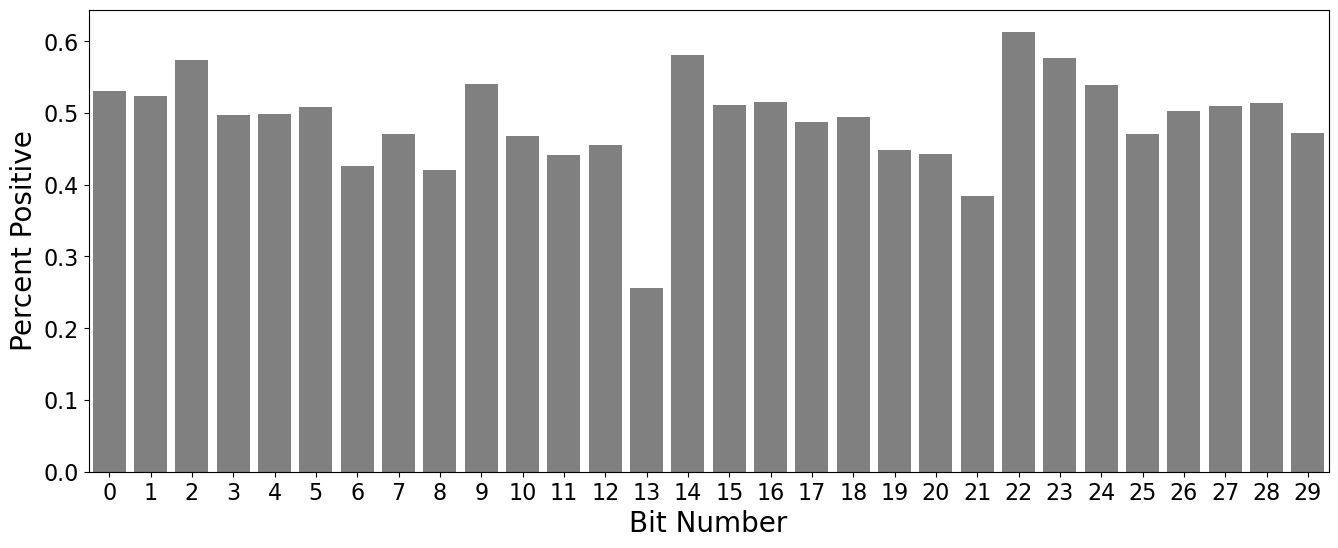

In [7]:
fig = plt.figure(figsize=(16, 6))
sns.barplot(x=list(range(len(bit_freq))), y=bit_freq, color="grey")
plt.xlabel("Bit Number",fontsize=20)
plt.ylabel("Percent Positive",fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig(snakemake_QC_outputs_path + "/Bit_Frequencies.png",dpi=300,bbox_inches="tight")
plt.show()

In [8]:
print("Number of Barcodes: " + str(n_barcodes_ttl))

Number of Barcodes: 133643


### Quantify Nearest Hamming Distances

In [4]:
dask_controller = tr_dask_controller(
    walltime="02:00:00",
    local=False,
    n_workers=40,
    memory="16GB",
    working_directory= dask_working_path,
)

dask_controller.startdask()

/home/de64/micromamba/envs/crispri/lib/python3.11/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home/de64/micromamba/envs/crispri/lib/python3.11/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
2024-09-18 15:14:53,261 - 

In [9]:
dask_controller.daskclient

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.120.16.229:8787/status,
Dashboard: http://10.120.16.229:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.120.16.229:43616,Workers: 0
Dashboard: http://10.120.16.229:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [8]:
dask_bit_arr = da.from_array(bit_arr,chunks=(10000,30)).astype("uint8")

In [9]:
dask_bit_arr

dask.array<array, shape=(15020, 30), dtype=uint8, chunksize=(10000, 30), chunktype=numpy.ndarray>

In [10]:
n_chunks = 5
step = dask_bit_arr.chunksize[0]*n_chunks
closest_match_list = []
for i in range(0,dask_bit_arr.shape[0],step):
    both_on = (dask_bit_arr[i:i+step]@dask_bit_arr.T).astype("uint8")
    both_off = ((-dask_bit_arr+1)[i:i+step]@(-dask_bit_arr.T+1)).astype("uint8")
    ttl_match = both_on+both_off
    hamming_dist = dask_bit_arr.shape[1] - ttl_match
    
    N = hamming_dist.shape[0]
    M = hamming_dist.shape[1]
    K = max(0,dask_bit_arr.shape[0]-(i+step))
    # print(f"i:{i}, N:{N}, K:{K}, M:{M}")
    if (i>0) and (K>0):
        zeros_arr_left = da.zeros((N,i)).astype(bool)
        zeros_arr_right = da.zeros((N,K)).astype(bool)
        diagonal_mask = da.eye(N).astype(bool)
        padded_diagonal_mask = da.concatenate([zeros_arr_left,diagonal_mask,zeros_arr_right],axis=1)
    elif (i>0):
        zeros_arr_left = da.zeros((N,i)).astype(bool)
        diagonal_mask = da.eye(N).astype(bool)
        padded_diagonal_mask = da.concatenate([zeros_arr_left,diagonal_mask],axis=1)
    else:
        zeros_arr_right = da.zeros((N,K)).astype(bool)
        diagonal_mask = da.eye(N).astype(bool)
        padded_diagonal_mask = da.concatenate([diagonal_mask,zeros_arr_right],axis=1)
    
    hamming_dist[padded_diagonal_mask] = 100
    closest_match = da.min(hamming_dist,axis=1)
    closest_match_list.append(closest_match.compute())

closest_match_list = np.concatenate(closest_match_list)


KeyboardInterrupt



In [10]:
with open(snakemake_QC_outputs_path + '/closest_match.npy', 'wb') as f:
    np.save(f, closest_match_list)

NameError: name 'closest_match_list' is not defined

### Plot Hamming Distance Distribution

#### These are not the plots we want in the final draft

The final distribution should come from the bit-subtracted histograms extractable from the final pandas df

- This is talking about the bit removal and soft hamming assignment procedure
- In other words, this hamming distirbution is going to depend on that bit subtraction

In [15]:
with open(snakemake_QC_outputs_path + '/closest_match.npy', 'rb') as f:
    closest_match_list = np.load(f)

In [16]:
closest_match_dict = {barcode:closest_match_list[k] for k,barcode in enumerate(barcodes)}

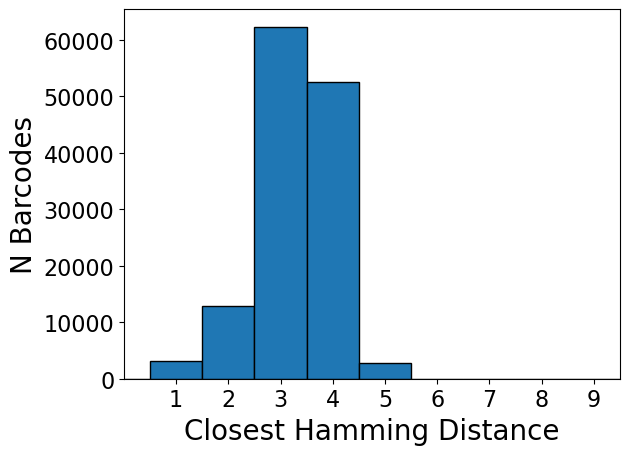

In [17]:
hist_count,hist_unique,_ = plt.hist(closest_match_list,bins=range(0,11),edgecolor="black")
hist_dict = dict(zip(hist_unique.astype(int),hist_count.astype(int)))
plt.xlabel("Closest Hamming Distance",fontsize=20)
plt.ylabel("N Barcodes",fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks([1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5],["1","2","3","4","5","6","7","8","9","10"])
plt.xlim(0.5,10)
plt.savefig(snakemake_QC_outputs_path + "/Closest_Hamming_Distance_Histogram.png",\
            dpi=300,bbox_inches="tight")
plt.show()

### Depth Distribution

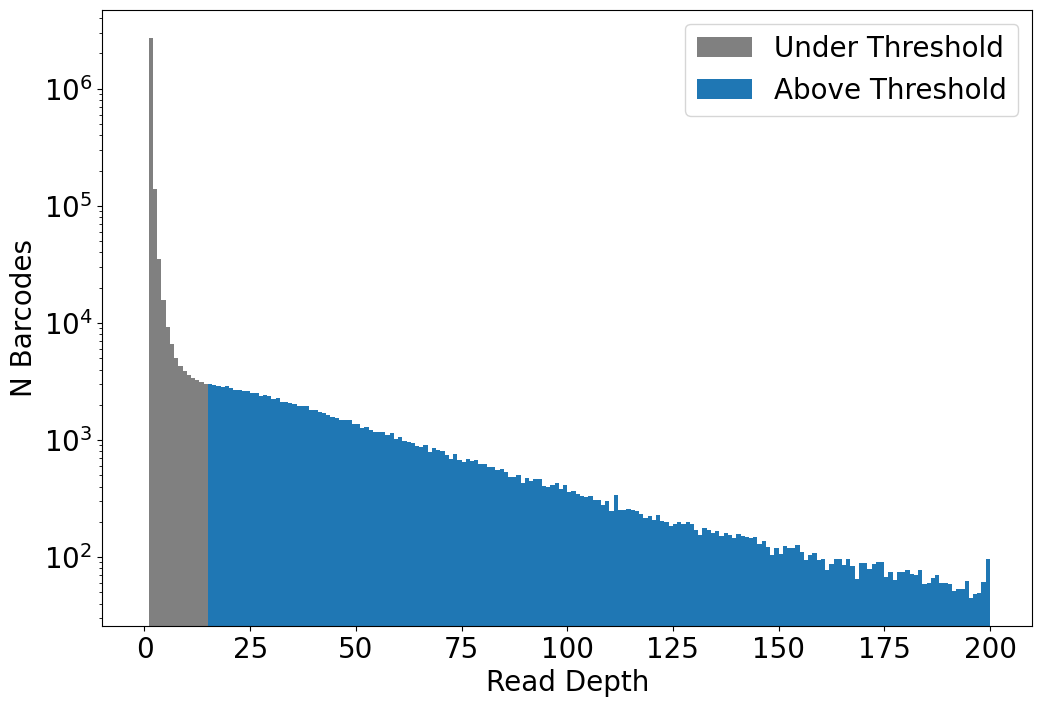

In [18]:
with open("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Sequencing/barcode_counts_dict.pkl", 'rb') as infile:
    depth_dict = pkl.load(infile)
depth_arr = np.array(list(depth_dict.values()))
n_reads_ttl = np.sum(depth_arr)
depth_threshold = 15

read_range = (0,200)

fig = plt.figure(figsize=(12, 8))

under_threshold_arr = depth_arr[depth_arr<depth_threshold]
above_threshold_arr = depth_arr[depth_arr>=depth_threshold]
plt.hist(under_threshold_arr, bins=200, range=read_range, log=True, color="grey", label="Under Threshold")
plt.hist(above_threshold_arr, bins=200, range=read_range, log=True, color="tab:blue", label="Above Threshold")
plt.xlabel("Read Depth",fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel("N Barcodes",fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.savefig(snakemake_QC_outputs_path + "/Read_Depth_Distribution.png",dpi=300,bbox_inches="tight")
plt.show()

## Output Variant Dataframe

In [19]:
sequencing_output_dd = dd.from_pandas(sequencing_output_df,npartitions=100).persist()

## Align consensus sequence to reference using cigar string
aligned_cons = sequencing_output_dd.apply(lambda x: align_read(x["consensus"],x["reference"],x["cigar"],startpos=x["alignmentstart"]),\
                                          axis=1,meta=str).persist()
## Use GFA reference to determine intervals for each annotation 
ref_intervals = get_ref_intervals(reference_gfa_path)
## Split sequences based on annotated intervals
split_ref = sequencing_output_dd.apply(lambda x: splitstr(x["reference"],ref_intervals), axis=1, meta=dict).persist()
split_align = aligned_cons.apply(lambda x: splitstr(x,ref_intervals), meta=dict).persist()

sequencing_output_dd["aligned_cons"] = aligned_cons
sequencing_output_dd["split_ref"] = split_ref
sequencing_output_dd["split_align"] = split_align

## Compute hamming distance from reference, by annotated element
hamm_ref = sequencing_output_dd.apply(lambda x: get_dict_dist(ast.literal_eval(x["split_align"]),ast.literal_eval(x["split_ref"])), axis=1, meta=dict).persist()

## Get promoters and UMIs
UMI = sequencing_output_dd["split_align"].apply(lambda x: ast.literal_eval(x)["Variant"][274:294], meta=str).persist()
sgRNA = sequencing_output_dd["split_align"].apply(lambda x: str(Seq(ast.literal_eval(x)["Variant"][175:195]).reverse_complement()), meta=str).persist()
## Assign closest match to each barcode (for costructing output df later)
closest_hamming_dist = sequencing_output_dd["barcode"].compute().apply(lambda x: closest_match_dict[x])

sequencing_output_dd["hamm_ref"] = hamm_ref
sequencing_output_dd["UMI"] = UMI
sequencing_output_dd["sgRNA"] = sgRNA
sequencing_output_dd["Closest Hamming Distance"] = closest_hamming_dist
sequencing_output_dd = sequencing_output_dd.persist()

del hamm_ref
del closest_hamming_dist
del aligned_cons
del split_align
del split_ref

sequencing_output_df_final = sequencing_output_dd.compute()

/home/de64/micromamba/envs/crispri/lib/python3.11/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 259.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/de64/micromamba/envs/crispri/lib/python3.11/site-packages/dask/dataframe/core.py:7365: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(
/home/de64/micromamba/envs/crispri/lib/python3.11/site-packages/dask/dataframe/core.py:7365: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(
/home/de64/mic

In [20]:
sgRNA_data = pd.read_csv(library_design_path,sep="\t")
sgRNA_dict = sgRNA_data["sgRNA Sequence"].to_dict()
sgRNA_inv_dict = {val:key for key,val in sgRNA_dict.items()}

valid_mask = sequencing_output_df_final["sgRNA"].isin(sgRNA_inv_dict.keys())
valid_data_df = sequencing_output_df_final[valid_mask]
index_map = valid_data_df["sgRNA"].apply(lambda x: sgRNA_inv_dict[x])
sgRNA_data_subset = sgRNA_data.loc[index_map.to_list()]

merged_df = valid_data_df.reset_index(drop=True).join(sgRNA_data_subset[["oDEPool7_id","EcoWG1_id","Gene","Strand","Target Sequence","Target Sites",\
                                                             "N Target Sites","N Mismatch","Category","TargetID"]].reset_index(drop=True))
merged_df['barcode depth'] = merged_df['barcode'].apply(lambda x: depth_dict[x])
n_barcodes = merged_df.groupby("sgRNA").size()

### Barcodes per Variant Distribution

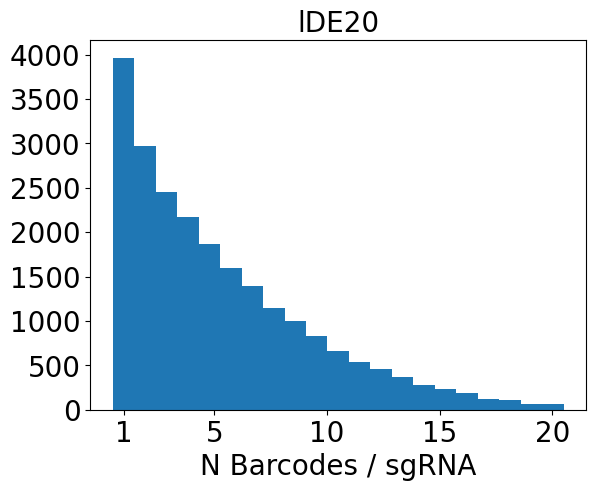

In [21]:
plt.title("lDE20",fontsize=20)
plt.hist(n_barcodes, bins=21, range=(1,21), log=False)
plt.xlabel("N Barcodes / sgRNA",fontsize=20)
plt.xticks(ticks=[1.5,5.5,10.5,15.5,20.5],labels=["1","5","10","15","20"],fontsize=20)
plt.yticks(fontsize=20)
plt.savefig(snakemake_QC_outputs_path + "/Barcodes_per_Variant_Distribution.png",\
            dpi=300,bbox_inches="tight")
plt.show()

In [23]:
## Storing dataframe as a csv
merged_df.to_csv("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Sequencing/lDE20_final_df.tsv",sep="\t")

In [25]:
dask_controller.shutdown()

TimeoutError: 1/1 nanny worker(s) did not shut down within 120s

In [8]:
test = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Imaging/Clustering/Pandas_Dataframe.pkl")

In [14]:
test[~test["L0"].isna()]

,Kernel Trace: Birth: Length,Kernel Trace: Division: Length,Kernel Trace: Delta: Length,Kernel Trace: Birth: Width,Kernel Trace: Division: Width,Kernel Trace: Delta: Width,Kernel Trace: Birth: Volume,Kernel Trace: Division: Volume,Kernel Trace: Delta: Volume,Kernel Trace: Final timepoints,...,Top_2_Genes_L0,Silhouette_Score_L1,Top_2_Genes_L1,Silhouette_Score_L2,Top_2_Genes_L2,Silhouette_Score_L3,Top_2_Genes_L3,Target Sequence,N Target Sites,Target Sites
oDEPool7_id,,,,,,,,,,,,,,,,,,,,,
9,"[2.7706593589854913, 2.770910160835989, 2.7710...","[5.565609431740329, 5.566527027024611, 5.56633...","[2.7949500727548378, 2.79561686618862, 2.79530...","[1.2436221396094478, 1.243798058980941, 1.2439...","[1.2537429069827752, 1.253945901950687, 1.2541...","[0.010120767373327897, 0.01014784296974603, 0....","[3.04183234067039, 3.041702600777197, 3.041734...","[6.068696036578007, 6.072228799545817, 6.07388...","[3.026863695907618, 3.0305261987686207, 3.0321...","[13.747569112055984, 14.83748096213227, 16.113...",...,dnaK\nfrr,0.651676,poxB\nglmU,0.504484,rpsI\npoxB,-0.090107,poxB\nhemE,ATCCAGCACCAACTCCCAGC,1.0,"[(605292, 605311, '-')]"
18,"[2.795983600801256, 2.789440305383647, 2.78160...","[5.527897414898182, 5.521241738659348, 5.51422...","[2.7319138140969264, 2.7318014332756997, 2.732...","[1.239163172496237, 1.239439471687737, 1.23951...","[1.236107233291245, 1.2359760926678491, 1.2357...","[-0.0030559392049920486, -0.003463379019887924...","[3.021639044700757, 3.0104550637985574, 2.9975...","[6.004851217019613, 5.991833915103887, 5.97703...","[2.983212172318857, 2.9813788513053288, 2.9794...","[13.465875544493015, 14.499881994495235, 15.71...",...,dnaK\nfrr,-0.090161,frr\nyqgE,-0.190986,frr\nnusA,-0.114543,frr\nrpmC,CTTTGCCACGCCGGAAGCGA,1.0,"[(605085, 605104, '-')]"
44,"[2.752100855261498, 2.7499348791796225, 2.7475...","[5.462971545879004, 5.461585072223673, 5.46096...","[2.7108706906175035, 2.7116501930440493, 2.713...","[1.2593537611854897, 1.258812678090388, 1.2581...","[1.2431127730758635, 1.2425113750860264, 1.241...","[-0.016240988109625806, -0.01630130300436163, ...","[3.0230428398008136, 3.0186152047890187, 3.013...","[5.9832954253806605, 5.976038920717968, 5.9683...","[2.960252585579848, 2.9574237159289494, 2.9547...","[12.855674056389484, 13.890967494953141, 15.08...",...,dnaK\nfrr,-0.492140,rlmE\nbamB,-0.281838,rnt\nrbfA,-0.251516,hemH\nispA,TATTTCCATCTGGATGTTCC,1.0,"[(3163046, 3163065, '-')]"
46,"[2.781115705289506, 2.7811899673308162, 2.7825...","[5.563804164117726, 5.571419907185877, 5.58123...","[2.782688458828219, 2.7902299398550605, 2.7986...","[1.2605943245968625, 1.2601645816483966, 1.259...","[1.2473977905845632, 1.2463663838063914, 1.245...","[-0.013196534012298821, -0.013798197842005588,...","[3.079488444763988, 3.0771050388324537, 3.0757...","[6.1426846991309185, 6.140348017553147, 6.1397...","[3.06319625436693, 3.063242978720694, 3.064087...","[13.004322462472123, 14.06161755172764, 15.292...",...,dnaK\nfrr,-0.384050,rlmE\nbamB,-0.041000,rnt\nrbfA,-0.233198,hemH\nispA,TATTTCCATCTGGATGTTCC,1.0,"[(3163046, 3163065, '-')]"
48,"[2.7380282371987663, 2.7494667327390867, 2.761...","[5.543894191926999, 5.55243289642233, 5.561301...","[2.805865954728232, 2.8029661636832426, 2.7998...","[1.2553040628625884, 1.2545560156600621, 1.253...","[1.236979127159818, 1.236447485883517, 1.23572...","[-0.01832493570277039, -0.018108529776545104, ...","[2.9763157878806195, 2.986311591159349, 2.9965...","[6.052808160533188, 6.057407892699315, 6.06044...","[3.07649237265257, 3.0710963015399653, 3.06393...","[14.050058763197296, 14.981359119507617, 16.06...",...,dnaK\nfrr,-0.032336,frr\nyqgE,-0.159030,rpsI\npoxB,-0.171928,rpsI\nyqhD,TATTTCCATCTGGATGTTCC,1.0,"[(3163046, 3163065, '-')]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29542,"[2.7294835511247713, 2.7260117118387868, 2.721...","[5.452502094401549, 5.445608212182791, 5.43732...","[2.723018543276778, 2.7195965003440032, 2.7153...","[1.258